### In previous sections, we abstract the recommendation task as a matrix completion problem without considering users’ short-term behaviors. 


The model we will introduce, Caser, short for convolutional sequence embedding recommendation model, adopts convolutional neural networks capture the dynamic pattern influences of users' recent activities.

- The main component of Caser consists of a horizontal convolutional network and a vertical convolutional network, aiming to uncover the union-level and point-level sequence patterns, respectively.

- Point-level pattern indicates the impact of single item in the historical sequence on the target item, while union level pattern implies the influences of several previous actions on the subsequent target.

### Model Architectures

In sequence-aware recommendation system, each user is associated with a sequence of some items from the item set.

Let $S^u = (S_1^u, ... S_{|S_u|}^u)$ denotes the ordered sequence.

$\mathbf{E}^{(u, t)} = [ \mathbf{q}_{S_{t-L}^u} , ..., \mathbf{q}_{S_{t-2}^u}, \mathbf{q}_{S_{t-1}^u} ]^\top$, where $\mathbf{Q} \in \mathbb{R}^{n \times k}$ represents item embeddings, considering $L$ items over time step $t$ and $\mathbf{E}^{(u, t)}$ is the input matrix for subsequent convolutional layers.

The horizontal convolutional layer has $d$ horizontal filters $\mathbf{F}^j \in \mathbb{R}^{h \times k}$ and the vertical convolutional layer has $d'$ vertical filters $\mathbf{G}^j \in \mathbb{R}^{ L \times 1}$

$\begin{split}\mathbf{o} = \text{HConv}(\mathbf{E}^{(u, t)}, \mathbf{F}) \\
\mathbf{o}'= \text{VConv}(\mathbf{E}^{(u, t)}, \mathbf{G}) \end{split}$, where $\mathbf{o} \in \mathbb{R}^d$ is the output of horizontal convolutional network and $\mathbf{o}' \in \mathbb{R}^{kd'}$ is the output of vertical convolutional network.

They are concatenated and fed into a fully-connected neural network layer to get more high-level representations. 

$\mathbf{z} = \phi(\mathbf{W}[\mathbf{o}, \mathbf{o}']^\top + \mathbf{b})$


The prediction function combines users’ short-term and general taste together, which is defined as: 

$\hat{y}_{uit} = \mathbf{v}_i \cdot [\mathbf{z}, \mathbf{p}_u]^\top + \mathbf{b}'_i$, where $\mathbf{V} \in \mathbb{R}^{n \times 2k}$ is item embedding matrix and $\mathbf{P} \in \mathbb{R}^{m \times k}$ is the user embedding matrix for users’ general tastes.

The model can be learned with BPR or Hinge loss. The architecture of Caser is shown below:

<img src="https://classic.d2l.ai/_images/rec-caser.svg" />

In [ ]:
!pip install mxnet-cu101==1.7.0

In [ ]:
!pip install d2l==0.17.5

In [1]:
import random
import mxnet as mx
from mxnet import gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

### Model Implementation

In [2]:
class Caser(nn.Block):
    def __init__(self, num_factors, num_users, num_items, L=5, d=16,
                 d_prime=4, drop_ratio=0.05, **kwargs):
        super(Caser, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.d_prime, self.d = d_prime, d
        # Vertical convolution layer
        self.conv_v = nn.Conv2D(d_prime, (L, 1), in_channels=1)
        # Horizontal convolution layer
        h = [i + 1 for i in range(L)]
        self.conv_h, self.max_pool = nn.Sequential(), nn.Sequential()
        for i in h:
            self.conv_h.add(nn.Conv2D(d, (i, num_factors), in_channels=1))
            self.max_pool.add(nn.MaxPool1D(L - i + 1))
        # Fully-connected layer
        self.fc1_dim_v, self.fc1_dim_h = d_prime * num_factors, d * len(h)
        self.fc = nn.Dense(in_units=d_prime * num_factors + d * L,
                           activation='relu', units=num_factors)
        self.Q_prime = nn.Embedding(num_items, num_factors * 2)
        self.b = nn.Embedding(num_items, 1)
        self.dropout = nn.Dropout(drop_ratio)

    def forward(self, user_id, seq, item_id):
        item_embs = np.expand_dims(self.Q(seq), 1)
        user_emb = self.P(user_id)
        out, out_h, out_v, out_hs = None, None, None, []
        if self.d_prime:
            out_v = self.conv_v(item_embs)
            out_v = out_v.reshape(out_v.shape[0], self.fc1_dim_v)
        if self.d:
            for conv, maxp in zip(self.conv_h, self.max_pool):
                conv_out = np.squeeze(npx.relu(conv(item_embs)), axis=3)
                t = maxp(conv_out)
                pool_out = np.squeeze(t, axis=2)
                out_hs.append(pool_out)
            out_h = np.concatenate(out_hs, axis=1)
        out = np.concatenate([out_v, out_h], axis=1)
        z = self.fc(self.dropout(out))
        x = np.concatenate([z, user_emb], axis=1)
        q_prime_i = np.squeeze(self.Q_prime(item_id))
        b = np.squeeze(self.b(item_id))
        res = (x * q_prime_i).sum(1) + b
        return res

### Sequential Dataset with Negative Sampling

<img src="https://classic.d2l.ai/_images/rec-seq-data.svg" />

In [3]:
class SeqDataset(gluon.data.Dataset):
    def __init__(self, user_ids, item_ids, L, num_users, num_items,
                 candidates):
        user_ids, item_ids = np.array(user_ids), np.array(item_ids)
        sort_idx = np.array(sorted(range(len(user_ids)),
                                   key=lambda k: user_ids[k]))
        u_ids, i_ids = user_ids[sort_idx], item_ids[sort_idx]
        temp, u_ids, self.cand = {}, u_ids.asnumpy(), candidates
        self.all_items = set([i for i in range(num_items)])
        [temp.setdefault(u_ids[i], []).append(i) for i, _ in enumerate(u_ids)]
        temp = sorted(temp.items(), key=lambda x: x[0])
        u_ids = np.array([i[0] for i in temp])
        idx = np.array([i[1][0] for i in temp])
        self.ns = ns = int(sum([c - L if c >= L + 1 else 1 for c
                                in np.array([len(i[1]) for i in temp])]))
        self.seq_items = np.zeros((ns, L))
        self.seq_users = np.zeros(ns, dtype='int32')
        self.seq_tgt = np.zeros((ns, 1))
        self.test_seq = np.zeros((num_users, L))
        test_users, _uid = np.empty(num_users), None
        for i, (uid, i_seq) in enumerate(self._seq(u_ids, i_ids, idx, L + 1)):
            if uid != _uid:
                self.test_seq[uid][:] = i_seq[-L:]
                test_users[uid], _uid = uid, uid
            self.seq_tgt[i][:] = i_seq[-1:]
            self.seq_items[i][:], self.seq_users[i] = i_seq[:L], uid

    def _win(self, tensor, window_size, step_size=1):
        if len(tensor) - window_size >= 0:
            for i in range(len(tensor), 0, - step_size):
                if i - window_size >= 0:
                    yield tensor[i - window_size:i]
                else:
                    break
        else:
            yield tensor

    def _seq(self, u_ids, i_ids, idx, max_len):
        for i in range(len(idx)):
            stop_idx = None if i >= len(idx) - 1 else int(idx[i + 1])
            for s in self._win(i_ids[int(idx[i]):stop_idx], max_len):
                yield (int(u_ids[i]), s)

    def __len__(self):
        return self.ns

    def __getitem__(self, idx):
        neg = list(self.all_items - set(self.cand[int(self.seq_users[idx])]))
        i = random.randint(0, len(neg) - 1)
        return (self.seq_users[idx], self.seq_items[idx], self.seq_tgt[idx],
                neg[i])

### Load the MovieLens 100K dataset

In [4]:
TARGET_NUM, L, batch_size = 1, 5, 4096
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_iter = d2l.load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_seq_data = SeqDataset(users_train, items_train, L, num_users,
                            num_items, candidates)
train_iter = gluon.data.DataLoader(train_seq_data, batch_size, True,
                                   last_batch="rollover",
                                   num_workers=d2l.get_dataloader_workers())
test_seq_iter = train_seq_data.test_seq
train_seq_data[0]

(array(0, dtype=int32),
 array([241., 170., 110., 255.,   4.]),
 array([101.]),
 791)

### Train the Model

train loss 1.573, test hit rate 0.380, test AUC 0.752
29.0 examples/sec on [gpu(0)]


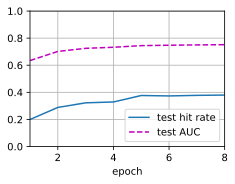

In [5]:
devices = d2l.try_all_gpus()
net = Caser(10, num_users, num_items, L)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.04, 8, 1e-5, 'adam'
loss = d2l.BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})

d2l.train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter,
                  num_users, num_items, num_epochs, devices,
                  d2l.evaluate_ranking, candidates, eval_step=1)